In [1]:
%pip install -q --upgrade keras-cv tensorflow
%pip install -q --upgrade keras
%pip install -q --upgrade tensorflow-io

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # you can also use tensorflow or torch

import keras
import keras_cv
import tensorflow as tf # only for data
import tensorflow_io as tfio # for loading .tif files

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 

2024-01-23 15:01:46.544636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 15:01:46.544720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 15:01:46.546232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "deeplab_v3_plus_resnet50_pascalvoc"  # Name of pretrained models
    image_size = [384, 384]  # Input image size
    epochs = 15 # Training epochs
    batch_size = 12  # Batch size
    drop_remainder = True  # Drop incomplete batches
    num_classes = 1 # Number of output classes
    cache = True # Save data into memory during training

In [5]:
keras.utils.set_random_seed(CFG.seed)

In [6]:
BASE_PATH = "/kaggle/input/blood-vessel-segmentation"

In [7]:
mask_paths = sorted(glob(f"{BASE_PATH}/train/*/labels/*tif"))
df = pd.DataFrame({"mask_path":mask_paths})
df['dataset'] = df.mask_path.map(lambda x: x.split('/')[-3])
df['slice'] = df.mask_path.map(lambda x: x.split('/')[-1].replace(".tif",""))

df = df[~df.dataset.str.contains("kidney_3_sparse")]
df['image_path'] = df.mask_path.str.replace("label","image")
df['image_path'] = df.image_path.str.replace("kidney_3_dense","kidney_3_sparse")
df.head()

,mask_path,dataset,slice,image_path
0,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0000,/kaggle/input/blood-vessel-segmentation/train/...
1,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0001,/kaggle/input/blood-vessel-segmentation/train/...
2,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0002,/kaggle/input/blood-vessel-segmentation/train/...
3,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0003,/kaggle/input/blood-vessel-segmentation/train/...
4,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0004,/kaggle/input/blood-vessel-segmentation/train/...


In [8]:
CHANNELS = 3 # take 3 slices to use "ImageNet" weights which require 3 channels
STRIDE = 3 # gap between each 2D slice

for i in range(CHANNELS):
    df[f'image_path_{i:02}'] = df.groupby(['dataset'])['image_path'].shift(-i*STRIDE).ffill()
df['image_paths'] = df[[f'image_path_{i:02d}' for i in range(CHANNELS)]].values.tolist()
df.image_paths[0]

['/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/0000.tif',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/0003.tif',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/0006.tif']

In [9]:
def build_decoder(with_labels=True, target_size=CFG.image_size, augment=False):
    def decode_image(paths):
        img_array = tf.TensorArray(dtype=tf.uint8, size=len(paths))
        for i in range(len(paths)):
            file_bytes = tf.io.read_file(paths[i])
            img0 = tfio.experimental.image.decode_tiff(file_bytes)[..., 0:1]
            img_array = img_array.write(i, img0[...,0])
        img = tf.transpose(img_array.stack(), perm=(1, 2, 0))
        img = tf.cast(img, tf.float32)
        img -= tf.reduce_min(img)
        img /= tf.reduce_max(img) + 0.001
        del img_array
        return img
    
    def decode_mask(mask_path):
        file_bytes = tf.io.read_file(mask_path)
        msk = tfio.experimental.image.decode_tiff(file_bytes)[...,0:1]
        msk = tf.cast(msk, tf.float32) / 255.0
        return msk

    def decode_without_labels(img_path):
        img = decode_image(img_path)
        img = tf.reshape(img, [*target_size, 3])
        return img
    
    def decode_with_labels(img_path, msk_path):
        img_msk = tf.concat([decode_image(img_path), decode_mask(msk_path)], axis=-1)
        img_msk = tf.image.random_crop(img_msk, [*target_size, 4])
        if augment:
            img_msk = apply_augmentations(img_msk)
        img = tf.reshape(img_msk[...,0:3], [*target_size, 3])
        msk = tf.reshape(img_msk[...,3:4], [*target_size, 1])
        return (img, msk)
    
    def apply_augmentations(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.rot90(img, k=np.random.randint(-3, 3))
        return img
    
    return decode_with_labels if with_labels else decode_without_labels


def build_dataset(img_paths, msk_paths=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(msk_paths is not None, augment=augment)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = img_paths if msk_paths is None else (img_paths, msk_paths)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

In [10]:
train_df = df[~df.dataset.str.contains('kidney_3')]
valid_df = df[df.dataset.str.contains('kidney_3')]
print('Num Train:', len(train_df), '| Num Valid:', len(valid_df))

Num Train: 5893 | Num Valid: 501


In [11]:
train_image_paths = train_df.image_paths.tolist()
train_mask_paths = train_df.mask_path.tolist()
train_ds = build_dataset(train_image_paths, train_mask_paths, batch_size=CFG.batch_size,
                         cache=CFG.cache, augment=True)

valid_image_paths = valid_df.image_paths.tolist()
valid_mask_paths = valid_df.mask_path.tolist()
valid_ds = build_dataset(valid_image_paths, valid_mask_paths, batch_size=CFG.batch_size,
                         cache=CFG.cache, repeat=False, shuffle=False, augment=False)

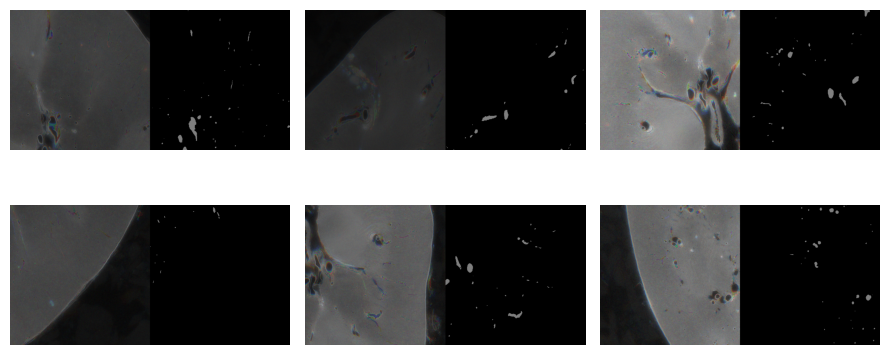

In [12]:
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch[0],
    value_range=(0, 1),
    num_classes=2,  # number of classes is 2 instead of 1 because of background.
    y_true=batch[1],
    scale=3,
    rows=2,
    cols=3,
)

In [13]:
from keras import ops

class DiceLoss(keras.losses.Loss):
    def __init__(self, smooth=1e-4, name="dice_loss"):
        super().__init__(name=name)
        self.smooth = smooth

    def call(self, y_true, y_pred):
        # Flatten label and prediction tensors
        y_true = ops.ravel(y_true)
        y_pred = ops.ravel(y_pred)

        # Compute the intersection & union
        intersection = ops.sum(y_true * y_pred)
        union = ops.sum(y_true) + ops.sum(y_pred)

        # Compute the Dice coefficient
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Return Dice loss
        return 1. - dice
    
class DiceCoef(keras.metrics.Metric):
    def __init__(self, name='dice_coef', smooth=1e-4, threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.smooth = smooth
        self.threshold = threshold
        self.intersection_sum = self.add_weight(name='intersection_sum', initializer='zeros')
        self.union_sum = self.add_weight(name='union_sum', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = ops.cast(y_pred > self.threshold, dtype="float32")
        y_true = ops.ravel(y_true)
        y_pred = ops.ravel(y_pred)

        intersection = ops.sum(y_true * y_pred)
        union = ops.sum(y_true) + ops.sum(y_pred)

        self.intersection_sum.assign_add(intersection)
        self.union_sum.assign_add(union)

    def result(self):
        dice = (2 * self.intersection_sum + self.smooth) / (self.union_sum + self.smooth)
        return dice

    def reset_states(self):
        self.intersection_sum.assign(0)
        self.union_sum.assign(0)
        
    def get_config(self):
        config = super().get_config()
        config.update({'smooth': self.smooth, 'threshold': self.threshold})
        return config

In [14]:
segmentation_head = keras.Sequential(
    [
        keras.layers.Conv2D(
            filters=32,
            kernel_size=1,
            padding="same",
            use_bias=False,
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear"),
        keras.layers.Conv2D(
            filters=CFG.num_classes,
            kernel_size=1,
            use_bias=False,
            padding="same",
            activation="sigmoid",
            dtype="float32",
        ),
    ], name="segmentation_head",
)

In [15]:
# Load the full DeepLabV3+ model
backbone = keras_cv.models.DeepLabV3Plus.from_preset(
    CFG.preset,
    input_shape=[*CFG.image_size, 3],
)

# Take only layers from backbone before head
neck_layer_name = backbone.layers[-2].name
out = backbone.get_layer(neck_layer_name).output

# Use newly defined head for segmentation
out = segmentation_head(out)

# Create a new model
model = keras.models.Model(inputs=backbone.input, outputs=out)

# Compile the model
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-4) # learning_rate)
METRICS = [
    DiceCoef(),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
LOSS = DiceLoss()  
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

# Model Sumamry
model.summary()

Attaching 'config.json' from model 'keras/deeplabv3plus/keras/deeplab_v3_plus_resnet50_pascalvoc/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deeplabv3plus/keras/deeplab_v3_plus_resnet50_pascalvoc/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deeplabv3plus/keras/deeplab_v3_plus_resnet50_pascalvoc/2' to your Kaggle notebook...


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │       0 │ -                    │
│ (InputLayer)        │ None, 3)          │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ functional_6        │ [(None, None,     │ 23,556… │ input_layer[0][0]    │
│ (Functional)        │ None, 256),       │         │                      │
│                     │ (None, None,      │         │                      │
│                     │ None, 2048)]      │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ spatial_pyramid_po… │ (None, None,      │ 15,538… │ functional_6[0][1]   │
│ (SpatialPyramidPoo… │ None, 256)        │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ encoder_output_ups… │ (None, None,      │       0 │ spatial_pyramid_poo… │
│ (UpSampling2D)      │ None, 256)        │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ sequential_6        │ (None, None,      │  12,480 │ functional_6[0][0]   │
│ (Sequential)        │ None, 48)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, None,      │       0 │ encoder_output_upsa… │
│ (Concatenate)       │ None, 304)        │         │ sequential_6[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ segmentation_head   │ (None, None,      │   9,888 │ concatenate[0][0]    │
│ (Sequential)        │ None, 1)          │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 39,117,152 (149.22 MB)

 Trainable params: 39,072,576 (149.05 MB)

 Non-trainable params: 44,576 (174.12 KB)

In [16]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 3e-5 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

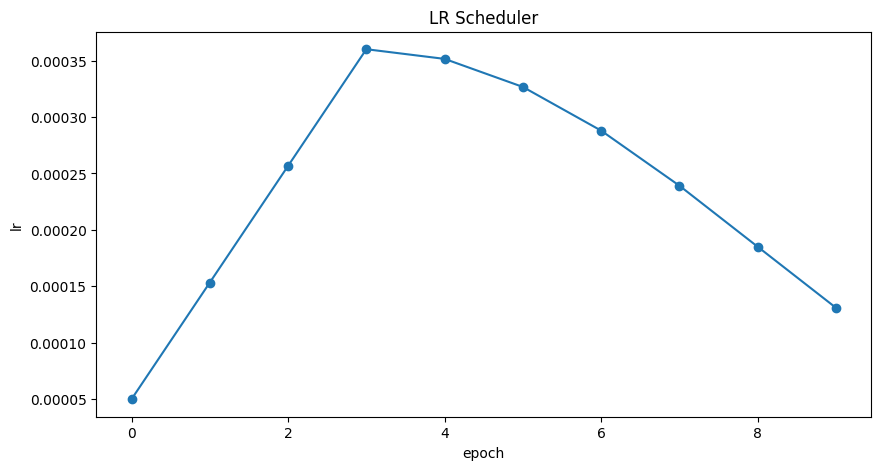

In [17]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

In [18]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_dice_coef',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='max')

In [19]:
history = model.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 532s 984ms/step - accuracy: 0.7591 - dice_coef: 0.0989 - loss: 0.9445 - val_accuracy: 0.9965 - val_dice_coef: 3.8358e-10 - val_loss: 0.9933 - learning_rate: 5.0000e-05
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 211s 429ms/step - accuracy: 0.9440 - dice_coef: 0.2894 - loss: 0.9010 - val_accuracy: 0.9965 - val_dice_coef: 3.8379e-10 - val_loss: 0.9935 - learning_rate: 1.5333e-04
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 211s 429ms/step - accuracy: 0.9877 - dice_coef: 0.6276 - loss: 0.6724 - val_accuracy: 0.2810 - val_dice_coef: 0.0089 - val_loss: 0.9926 - learning_rate: 2.5667e-04
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 208s 424ms/step - accuracy: 0.9956 - dice_coef: 0.8128 - loss: 0.2658 - val_accuracy: 0.9965 - val_dice_coef: 0.0024 - val_loss: 0.9885 - learning_rate: 3.6000e-04
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 211s 429ms/step - accuracy: 0.9965 - dice_coef: 0.8536 - loss: 0.1810 - val_accuracy: 0.9965 - val_dice_coef: 0.0320 - val_loss: 0.9738 

In [20]:
model.load_weights("best_model.keras")

In [21]:
thrs = np.linspace(0, 1, 20)
results = []
for thr in tqdm(thrs, desc="Searching best thr "):
    dice_coef = DiceCoef(threshold=thr)
    for (imgs, msks) in valid_ds:
        imgs = ops.convert_to_tensor(imgs)
        msks = ops.convert_to_tensor(msks)
        preds = model(imgs)
        dice_coef.update_state(msks, preds)
    results.append(np.array(dice_coef.result()))
results = np.array(results)

Searching best thr :   0%|          | 0/20 [00:00<?, ?it/s]

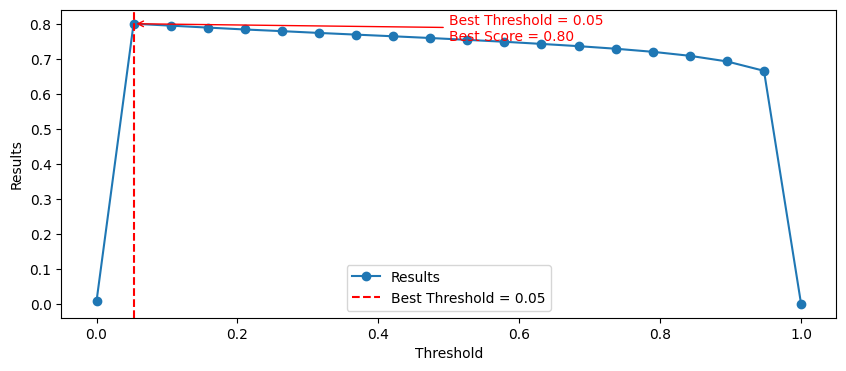

In [22]:
# Find the best threshold and best score
BEST_THR = thrs[np.argmax(results)]
BEST_SCORE = max(results)

# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(thrs, results, marker='o', label='Results',)
plt.axvline(BEST_THR, color='red', linestyle='--', label=f'Best Threshold = {BEST_THR:.2f}')

# Calculate relative coordinates based on figure size
x_relative = 0.5  # Adjust as needed
y_relative = 0.9  # Adjust as needed

# Convert relative coordinates to absolute coordinates
x_absolute = x_relative * (plt.xlim()[1] - plt.xlim()[0]) + plt.xlim()[0]
y_absolute = y_relative * (plt.ylim()[1] - plt.ylim()[0]) + plt.ylim()[0]

plt.annotate(f'Best Threshold = {BEST_THR:.2f}\nBest Score = {BEST_SCORE:.2f}', 
             xy=(BEST_THR, BEST_SCORE), xytext=(x_absolute, y_absolute),
             arrowprops=dict(arrowstyle='->', color='red'), color='red')
plt.xlabel('Threshold')
plt.ylabel('Results')
plt.legend()
plt.show()

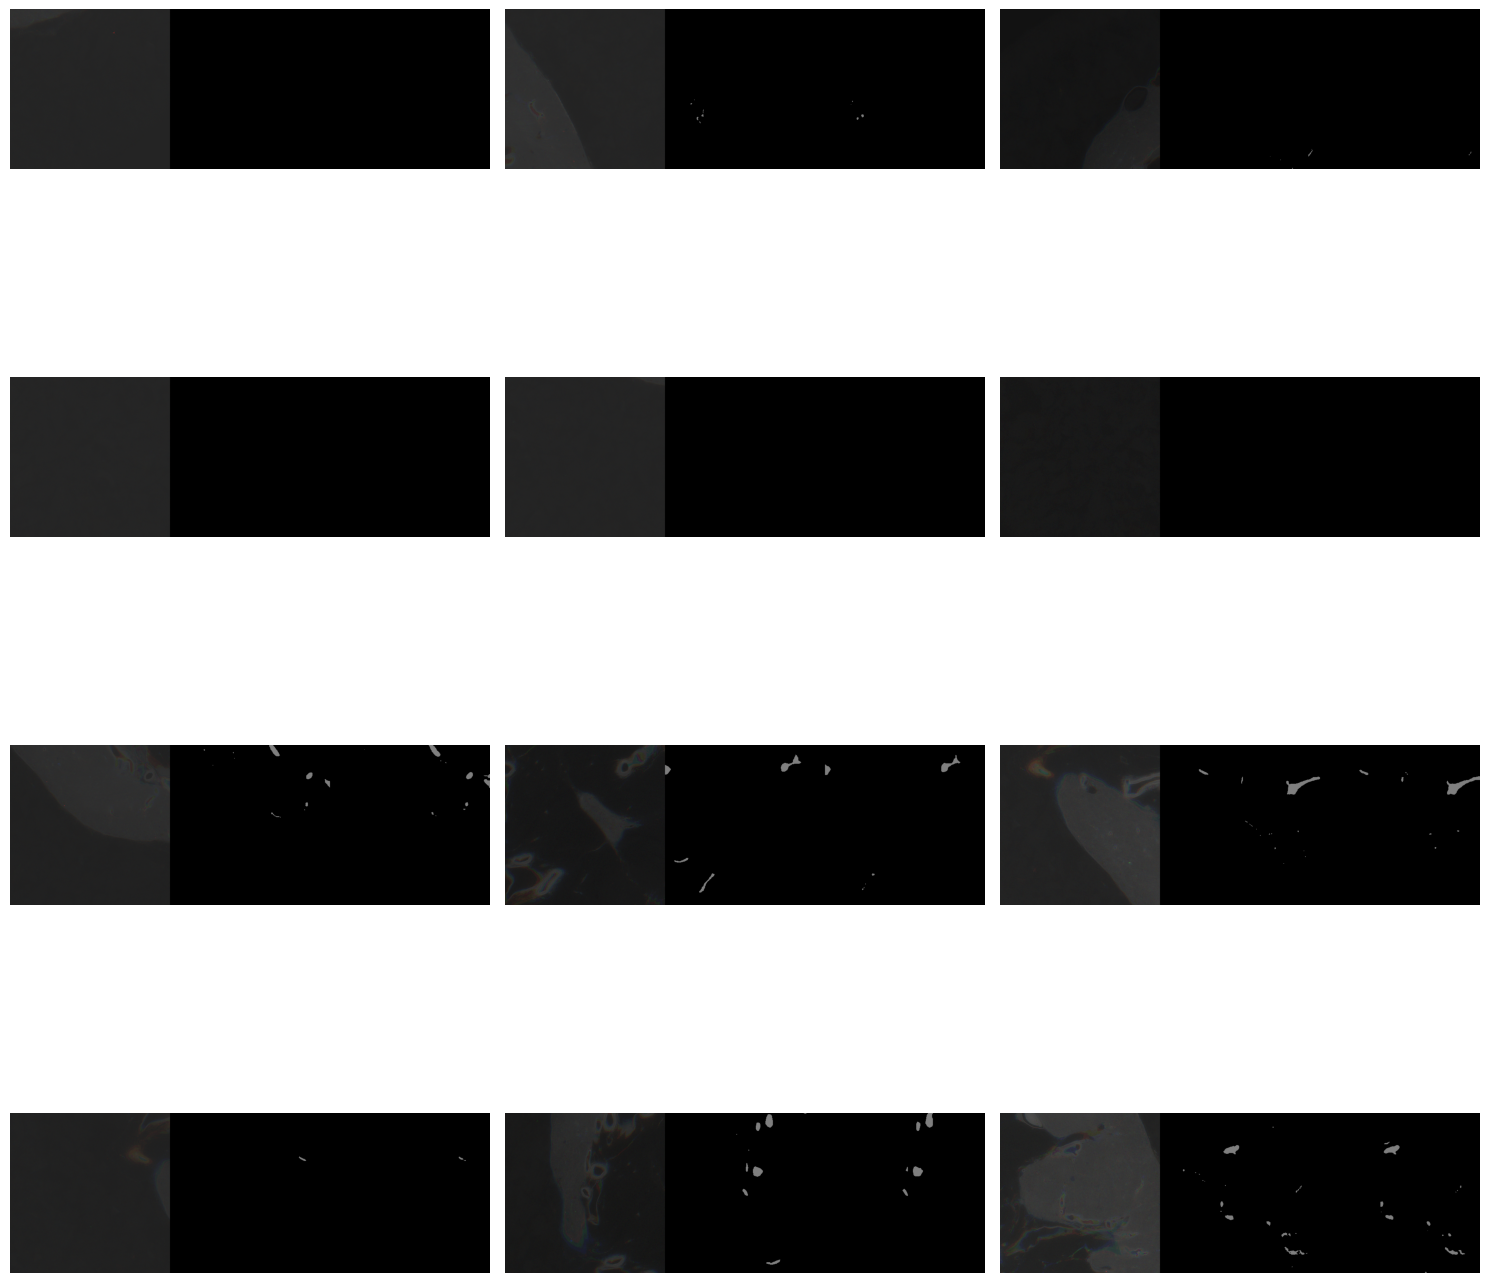

In [23]:
images, masks = next(iter(valid_ds.take(1)))
images = ops.convert_to_tensor(images)
masks = ops.convert_to_tensor(masks)
preds = ops.cast(model(images) > BEST_THR, "float32")

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=2,
    y_true=masks,
    y_pred=preds,
    scale=5,
    rows=4,
    cols=3,)